# SDM EXPERIMENTS
This notebook is for conducting various experiments with Sparse Distributed Memory including:    
1) Denoising images    
2) Categorizing images    
3) Bidirectional image system (highly likely to fail method)    
4) Bidirectional image system (separate forward and backwards writing)    
5) Unsupervised perceptual memory (if not known, write it new)    

### Thoughts
Ok so far its been a bit hit and miss. On the success side we can write to the memory and successfully retrieve mnist digits perfectly with some tweaking of parameters such as the radius. On the down side, this success only seems to work for a small number of writes (up to 50 images seems to work 100 definitely doesn't) The issue seems to be overlapping patterns which result in bad reads. Denoising can fail for even noiseless images as a result. This suggests that the capacity of the memory is decreasing a lot and the critical distance goes to zero. There are formulas in kanerva's book to estimate these values so it might be worthwhile reading up on that. Maybe dynamic radius's will work? I found by trial and error that 337 works good for a single batch of 10 images

Ultimately I think a large part of the problem is that the images are located in a subspace of the total 784 dimensional space and as a result the patterns are overwritting each other. This might spell the end for this project but its also possible that by breaking up the image into small pieces the variance of those pieces will be more diverse and memory won't fail as easily. my concern here is that SDM works worse for smaller dimensional spaces. 

Maybe this could be overcome by first passing the digits through some sort of feature extractor into a high dimensional space followed by writing into memory. we could use gabor filters directly or train a CNN as a feature extractor then use the lowest couple of layers? Ideally we would use either an unsupervised method or a fixed method but maybe we can stretch things a bit.

Also I'm not sure how well SDM works when writing to similar addresses. Maybe some conditional writing should be tried. if a pattern converges don't write it? if it doesn't then do. Then again... what is the average hamming distance between any pair of numbers...

That would be a very good statistic to use for diagnosis.

Take 2: A lot of the properties of the SDM rely on the proportion of space each read accesses (p) which is related to the radius of access ($r_p$). Unfortunately the relationship between these two relies on the CDF of the normal function or a sum of binomial coefficients. Neither one is appealing. BUT we can fairly easily use a bisection method to determine what $r_p$ should be. We can do random reads and see what value of r activates p proportion of the hard addresses. This could possibly be done without bisection method if a sort were performed. Return the distances to each node, sort them and then find the value of r by looking at the entry exactly pth way through and figure what r should be to activate those.

its hard to tell which way would be faster tbh

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda:3'
print(torch.__version__)
from dennytools.silence import *

from SDM import SDM, AWSDM, tent

1.2.0


In [2]:
BS = 10

train = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)

## Experiment 1 - Denoising Images
In this experiment we are going to do the simple task of writing images into memory under their own data as an address and will perform nearest neighbour searching of noising images in order to denoise them. We will also test how much noise can be applied on average and how many attempted iterations we need to determine a read failure 

In [21]:
Adim = 784
Mdim = 784
Nloc = 100000

WriteBatches = 50

mem = AWSDM(Adim, Mdim, Nloc, dtype=torch.int32, weightFunc=tent).to(device)
mem.radius = 62

savelist = [0,5,10,20,30,40,55,100,200,500]

batches = 0
imgs = []
initdata = None
# Write all the data in
for (data, label) in train:
    if (batches < 10 or (batches < 100 and batches%10 == 0) or batches%100==0):
        print (batches)
    
    data = (data.view(-1, 784) > 0).byte().to(device)
    if (initdata is None):
        initdata = data
        imgs.append(initdata)
        
    mem.write(initdata, initdata)
    if (batches in savelist):
        imgs.append(mem.read(initdata))
    
    batches += 1
    if (batches == WriteBatches):
        break
    
# Read out one batch
# (data, label) = next(iter(train))

dprime = mem.read(initdata)

print ((dprime == initdata).sum().item()/data.storage().size())


0
1
2
3
4
5
6
7
8
9
10
20
30
40
0.797704081632653


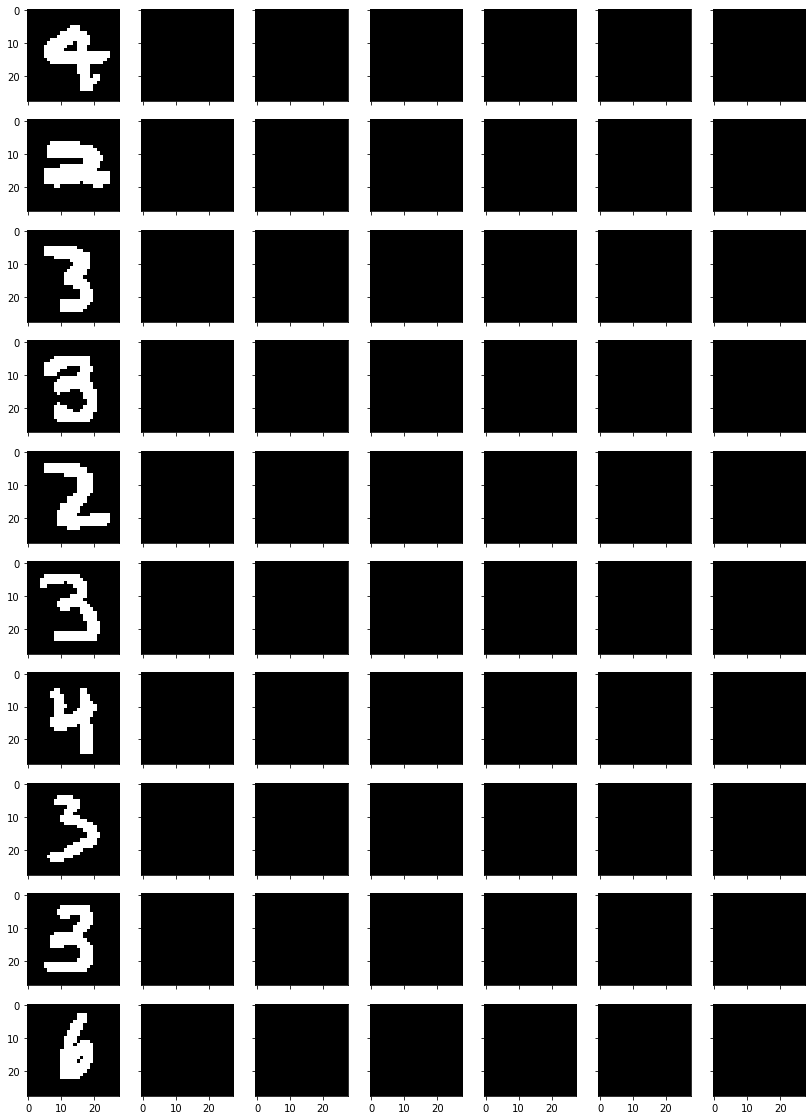

In [23]:
def display(imgs, shape=(28,28)):
    
    if (len(imgs) == 1):
        rows = math.ceil(imgs[0].shape[0]/5)
        cols = 5
        fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(2*cols, 2*rows))
        for i in range(imgs[0].shape[0]):
            px = i//cols
            py = i%cols
            ax[px,py].imshow(imgs[0][i].view(shape).detach().cpu(), cmap='gray', vmin=0, vmax=1)
        plt.show()        
    else:
        rows = imgs[0].shape[0]
        cols = len(imgs)
        fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(2*cols, 2*rows))
        for c, img in enumerate(imgs):
            py = c
            for i in range(img.shape[0]):
                px = i 
                ax[px,py].imshow(img[i].view(shape).detach().cpu(), cmap='gray', vmin=0, vmax=1)
        plt.show()
    

display(imgs, (28,28))

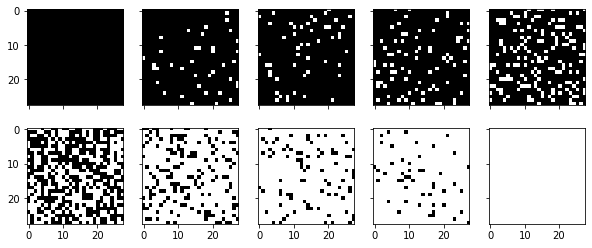

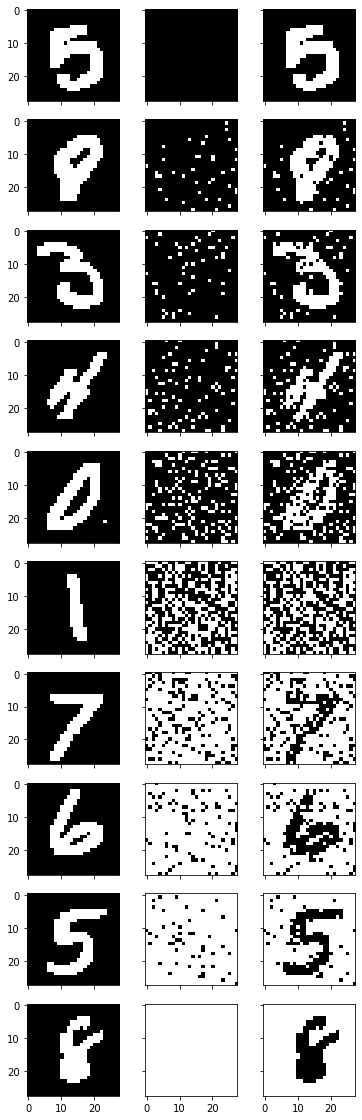

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9


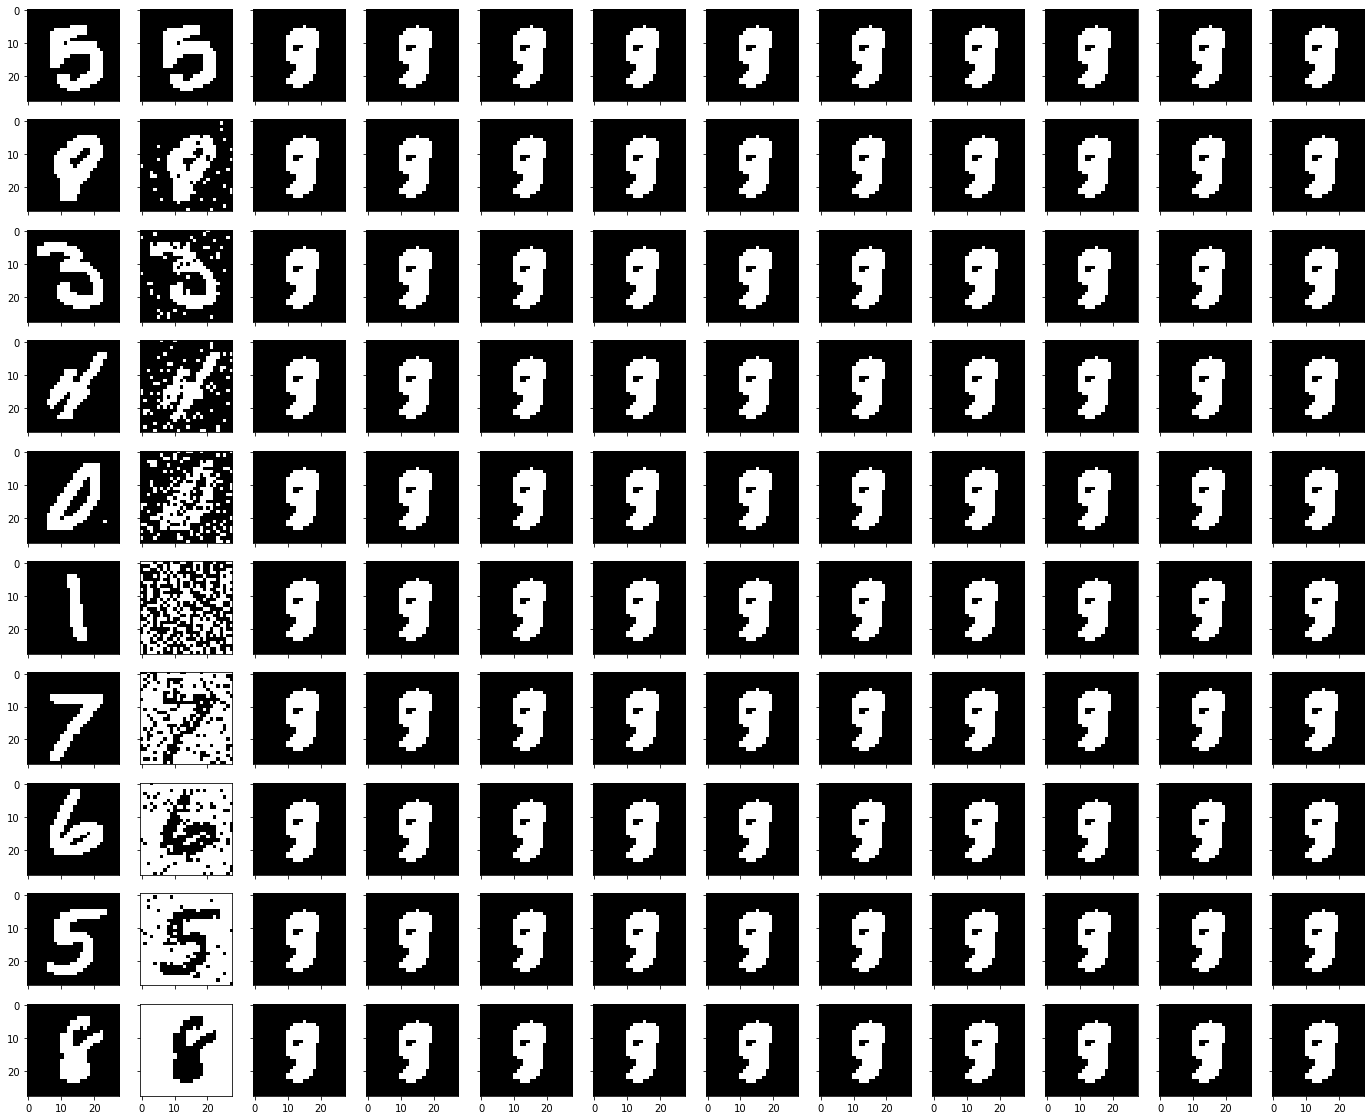

In [5]:
steps = 10
nclasses = 10

data = initdata

# noisescale = torch.linspace(0,1,data.shape[0]).unsqueeze(-1).to(device)
noisescale = torch.tensor([0, 0.05, 0.07, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1]).unsqueeze(-1).to(device)
noise = torch.rand_like(data, dtype=torch.float)
noise = (noise < noisescale).byte()
display([noise], (28,28))

noisyData = (noise + data)%2
display([data, noise, noisyData], (28,28))

imgs = []
imgs.append(data)
imgs.append(noisyData)
for i in range(steps):
    if (i < 10 or (i < 100 and i%10 == 0) or i%100==0):
        print ("step {}".format(i))
        
    noisyData = mem.read(noisyData)
    imgs.append(noisyData)
    
display(imgs)
    

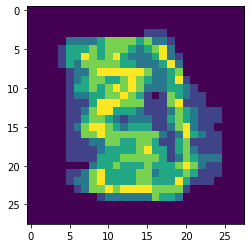

In [22]:
# print (mem.means[:100])
# print (mem.weightFunc(mem.means[:100]))
w = (mem.weightFunc(mem.means))
plt.imshow(w.view(28,28).cpu())
plt.show()

In [ ]:
#Write only if not in memory


Adim = 784
Mdim = 784
Nloc = 100000

WriteBatches = 5

mem = SDM(Adim, Mdim, Nloc, dtype=torch.int32).to(device)
mem.radius = 337

savelist = [0,5,10,20,30,40,55,100,200,500]

batches = 0
imgs = []
initdata = None
# Write all the data in
for (data, label) in train:
    if (batches < 10 or (batches < 100 and batches%10 == 0) or batches%100==0):
        print (batches)
    
    data = (data.view(-1, 784) > 0).byte().to(device)
    if (initdata is None):
        initdata = data
        imgs.append(initdata)
        
    mem.write(data, data)
    if (batches in savelist):
        imgs.append(mem.read(initdata))
    
    batches += 1
    if (batches == WriteBatches):
        break
    
# Read out one batch
# (data, label) = next(iter(train))

dprime = mem.read(initdata)

print ((dprime == initdata).sum().item()/data.storage().size())

## Experiment 1b - Determining Parameters

The poor results in the previous section (not being able to write NEARLY the number of items I would expect) has led me to suspect that the problem might be due to the  fact that the MNIST digits actually exist in a subspace of the address space (for example most digits have black borders resulting in this part of addressing space being useless). So what I want to do here is attempt to figure out the effective dimension of the digit set. I plan on doing that by:    
1) Looking at which bit positions have between an x and 1-x probability of being on. These are the points which will contribute the largest.    
2) Plot the variance of the bit positions to get a smoother image of the above    
3) Measure the min mean and max distance between bit vectors both inside a class and between classes.     

In [7]:
exp1a = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=100, shuffle=True, pin_memory=False)

In [ ]:
mu = torch.zeros((784))
for (data, label) in exp1a:
    data = (data.view(-1, 784) > 0).float()
    mu += data.mean(0)
mu = mu / len(exp1a)

In [ ]:
plt.imshow(mu.view(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

clip = (mu>0.1).float() * (mu<0.6).float()# * mu<0.6
print ((clip>0).sum())

plt.imshow(clip.view(28,28), cmap='gray', vmin=0, vmax=1)
plt.show()

plt.hist(mu, bins=50)
plt.show()

In [ ]:
md = 0
for (data, label) in exp1a:
    data = (data.view(-1, 784) > 0).float()
    dist = ((data.unsqueeze(0) + data.unsqueeze(1))%2).sum(-1)
#     print (dist)
#     print (dist.mean())
#     break
    md += dist.mean().item()
print (md/len(exp1a))

An even better measure might be to look at what percentage of hard addresses are actually being activated.

In [27]:
Adim = 784
Mdim = 784
Nloc = 100000

# exp1a_mem = SDM(Adim, Mdim, Nloc, dtype=torch.int32)
exp1a_mem = mem.cpu()

mas = np.zeros(Adim+1)

runs = 1
for i, (data, label) in enumerate(exp1a):
    if (i == runs):
        break
        
    print("Run = {}".format(i))
    
    data = (data.view(-1, 784) > 0).float()
    active = exp1a_mem._getActive(data, distance=True).squeeze()
    print (active.min())
    break
    
    for radius in range(Adim+1):
#         print (radius)
#         print ((((active + radius) >=0 ).sum(0)>0))
#         mas[radius] += ((active + radius) >=0 ).float().sum(-1).mean().item()/runs
        mas[radius] += ((active <= radius).sum(0)>0).sum().item()/runs
#         mas[radius] += (((active + radius) >=0 ).sum(0)>0).sum().item()/runs
        

Run = 0
tensor(131.5527)


In [11]:
masr = np.zeros(Adim+1)

data = torch.randint(0,2,(100,Adim)).float()
active = exp1a_mem._getActive(data, distance=True).squeeze()

for radius in range(Adim+1):
#     masr[radius] += ((active + radius) >=0 ).float().sum(-1).mean().item()
#     masr[radius] += (((active + radius) >=0 ).sum(0)>0).sum().item()
    masr[radius] += ((active <= radius).sum(0)>0).sum().item()
        

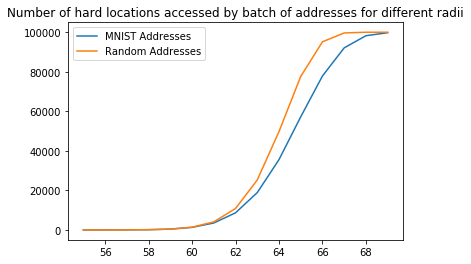

In [14]:
start = 55
end = 70

x = np.arange(start, end)

plt.plot(x,mas[start:end], label='MNIST Addresses')
plt.plot(x,masr[start:end], label='Random Addresses')
plt.legend()
plt.title('Number of hard locations accessed by batch of addresses for different radii')
plt.show()

## Experiment 2 - Categorizing images through recognition
In this experiment, I'm going to attempt categorizing images by writing the one-hot encoded labels into memory to start, the second attempt would be to appen

In [ ]:

label = label.unsqueeze(-1).to(device)
ohlabel = torch.zeros((data.shape[0], nclasses)).to(device)
label = ohlabel.scatter_(1, label, 1)